In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import preprocessing
from cvxopt import matrix 
from cvxopt import solvers
from sklearn.preprocessing import StandardScaler

In [2]:
def Hard_Margin(X,y):
    #Initializing values and computing H.
    m,n = X.shape
    X_dash = y * X
    H = np.dot(X_dash , X_dash.T) * 1.

    #Converting into cvxopt format
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    G = matrix(-np.eye(m))
    h = matrix(np.zeros(m))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))

    #Run solver
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    
    return alphas

In [3]:
def Soft_Margin(X,y,C):
    
    m,n = X_train.shape
    X_dash = y * X_train
    H = np.dot(X_dash , X_dash.T) * 1.

    #Converting into cvxopt format - as previously
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))

    #Run solver
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    return alphas

In [4]:
def linear(x, z):
    return np.dot(x, z.T)
 
def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p
 
def rbf(x, z, sigma=0.13):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

In [5]:
class Non_linear:
    def __init__(self, kernel=rbf, C=1):
        self.kernel = kernel
        self.C = C
 
    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape
 
        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)
 
        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = matrix(np.outer(y, y) * self.K)
        q = matrix(-np.ones((m, 1)))
        G = matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = matrix(y, (1, m), "d")
        b = matrix(np.zeros(1))
        solvers.options["show_progress"] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])
 
    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv,x,z = self.get_parameters(self.alphas)
 
        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )
 
        return np.sign(y_predict + self.b)
 
    def get_parameters(self, alphas):
        threshold = 1e-5
 
        sv = (((alphas > threshold) & (alphas < self.C))).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv,self.w,self.b

In [6]:
def predict(X,w,b):
    return  np.sign(np.dot(X_test, w) + b).flatten()

In [7]:
def calculate_accuracy(predicted_y,y):
    accuracy = np.mean(predicted_y == y)
    return accuracy

In [8]:
def calculate_error(acc1, acc2):
    error =((1-acc1) + (1-acc2))/2
    return error

In [9]:
def create_dataset(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels
 
    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
 
    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
 
    y[y == 0] -= 1
 
    return X, y

## Hard Margin

In [10]:
data=datasets.load_iris()
X=np.array(data.data)
y=np.array(data.target)

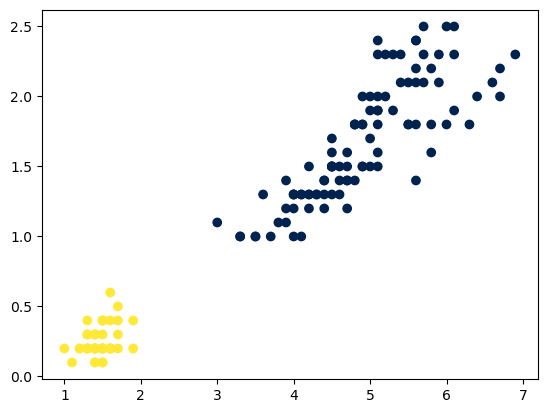

In [11]:
X=np.delete(X, np.array([0,1]), axis = 1)
y_=[]
for i in y:
    if i==0:
        y_.append(1)
    else:
        y_.append(-1)
y=np.array(y_)
plt.scatter(X[:,0], X[:,1], c=y, cmap ='cividis')

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
y_train = y_train.reshape(-1,1) * 1.
alphas = Hard_Margin(X_train,y_train)
w = ((y_train * alphas).T @ X_train).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y_train[S] - np.dot(X_train[S], w)
b=b[0]
#Display results
print('Alphas = ',alphas[S])
print('w = ', w.flatten())
print('b = ', b)
y_predict =  predict(X_test,w,b)
y_predict2 =  predict(X_valid,w,b)
acc1 = calculate_accuracy(y_predict,y_test)
acc2 = calculate_accuracy(y_predict2,y_valid)
print('error = ',calculate_error(acc1,acc2))

     pcost       dcost       gap    pres   dres
 0: -1.6275e+01 -3.3723e+01  4e+02  2e+01  2e+00
 1: -2.1162e+01 -1.7430e+01  1e+02  6e+00  7e-01
 2: -4.1205e+00 -3.4572e+00  3e+01  1e+00  1e-01
 3: -2.5966e-01 -2.2909e+00  2e+00  5e-16  8e-16
 4: -6.1331e-01 -2.2363e+00  2e+00  5e-16  7e-16
 5: -1.6067e+00 -1.8916e+00  3e-01  3e-16  1e-15
 6: -1.8279e+00 -1.8379e+00  1e-02  3e-16  1e-15
 7: -1.8363e+00 -1.8364e+00  1e-04  4e-16  1e-15
 8: -1.8364e+00 -1.8364e+00  1e-06  4e-16  1e-15
Optimal solution found.
Alphas =  [[1.83636143]
 [1.83636339]]
w =  [-1.47327687 -1.22563601]
b =  [-1.74984058]
error =  0.2


In [14]:
def plot(X_train,X_test,y_train,y_test,w,b):  
    def get_hyperplane(x, w, b, offset):
            return (-w[0] * x - b + offset) / w[1]

    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    plt.set_cmap('PiYG')
    plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, s=100, alpha=0.75)
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="x", c=y_test, s=100, alpha=0.75)

    x0_1 = np.amin(X_train[:, 0])
    x0_2 = np.amax(X_train[:, 0])

    x1_1 = get_hyperplane(x0_1, w, b, 0)
    x1_2 = get_hyperplane(x0_2, w, b, 0)

    x1_1_m = get_hyperplane(x0_1, w, b, -1)
    x1_2_m = get_hyperplane(x0_2, w, b, -1)

    x1_1_p = get_hyperplane(x0_1, w, b, 1)
    x1_2_p = get_hyperplane(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "-", c='k', lw=1, alpha=0.9)
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "--", c='grey', lw=1, alpha=0.8)
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "--", c='grey', lw=1, alpha=0.8)

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

    plt.show()

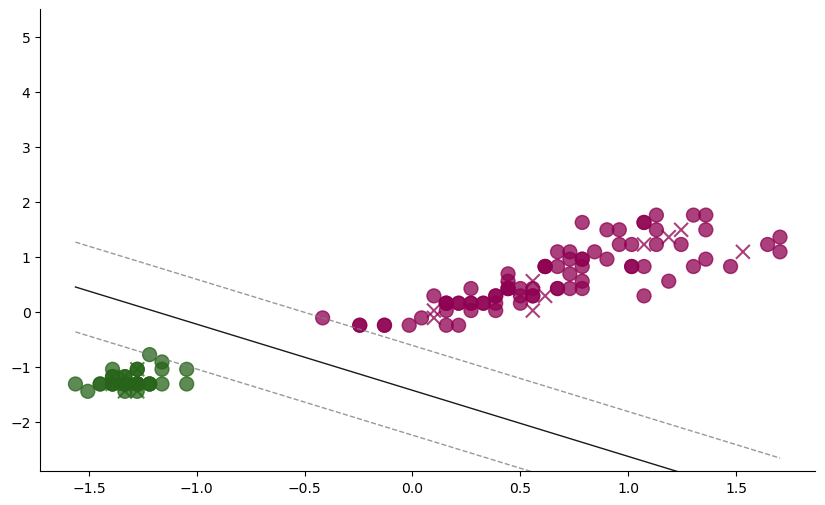

In [15]:
plot(X_train,X_test,y_train,y_test,w,b)

## Soft Margin

In [16]:
data=datasets.load_iris()
X=np.array(data.data)
y=np.array(data.target)

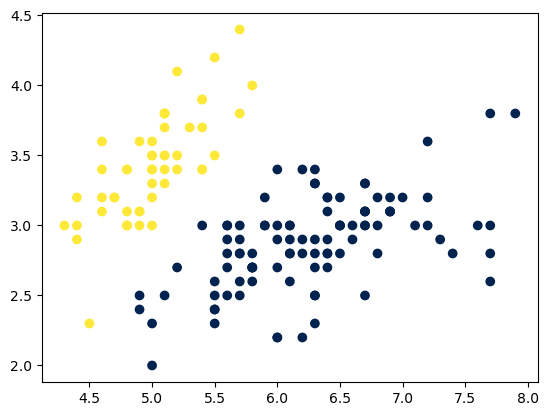

In [17]:
X=np.delete(X, np.array([2,3]), axis = 1)
y_=[]
for i in y:
    if i==0:
        y_.append(1)
    else:
        y_.append(-1)
y=np.array(y_)
plt.scatter(X[:,0], X[:,1], c=y, cmap ='cividis')

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42)

In [19]:
C = 0.1
y_train = y_train.reshape(-1,1) * 1.
alphas = Soft_Margin(X_train,y_train,C)
w = ((y_train * alphas).T @ X_train).reshape(-1,1)
S = ((alphas > 1e-4 )&(alphas <=C)).flatten()
b = y_train[S] - np.dot(X_train[S], w)
b = b[0]

#Display results
print('Alphas = ',alphas[S])
print('w = ', w.flatten())
print('b = ', b[0])
y_predict =  predict(X_test,w,b)
y_predict2 =  predict(X_valid,w,b)
acc1 = calculate_accuracy(y_predict,y_test)
acc2 = calculate_accuracy(y_predict2,y_valid)
print('error = ',calculate_error(acc1,acc2))

     pcost       dcost       gap    pres   dres
 0: -1.2902e+01 -2.1071e+01  6e+02  2e+01  4e-14
 1: -3.0649e+00 -1.9616e+01  4e+01  1e+00  3e-14
 2: -2.2532e+00 -8.2262e+00  6e+00  6e-03  5e-15
 3: -2.7525e+00 -3.8315e+00  1e+00  1e-03  4e-15
 4: -3.0879e+00 -3.3365e+00  2e-01  2e-04  5e-15
 5: -3.1894e+00 -3.2158e+00  3e-02  1e-05  5e-15
 6: -3.1988e+00 -3.2011e+00  2e-03  5e-07  5e-15
 7: -3.1997e+00 -3.1998e+00  5e-05  7e-09  6e-15
 8: -3.1998e+00 -3.1998e+00  5e-07  7e-11  6e-15
Optimal solution found.
Alphas =  [[0.1       ]
 [0.1       ]
 [0.09999999]
 [0.1       ]
 [0.09999999]
 [0.1       ]
 [0.1       ]
 [0.1       ]
 [0.09999999]
 [0.0972516 ]
 [0.1       ]
 [0.1       ]
 [0.09999998]
 [0.1       ]
 [0.09999999]
 [0.08450174]
 [0.1       ]
 [0.09999999]
 [0.09999999]
 [0.09999999]
 [0.1       ]
 [0.1       ]
 [0.1       ]
 [0.09277419]
 [0.1       ]
 [0.09999999]
 [0.1       ]
 [0.1       ]
 [0.09604787]
 [0.09999999]
 [0.09999999]
 [0.1       ]
 [0.09999999]
 [0.02942996]
 

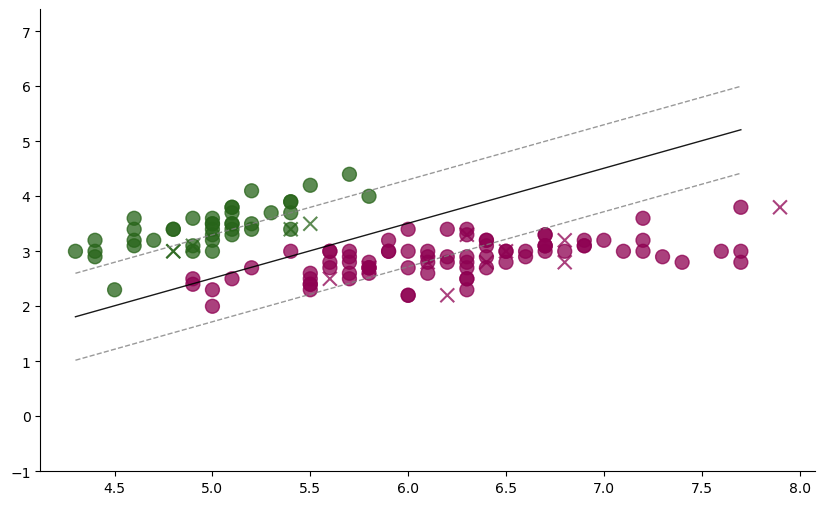

In [20]:
plot(X_train,X_test,y_train,y_test,w,b)

## Non-linear

In [21]:
def plotdata(X,y):
        pos = y == 1
        neg = y == -1
        plt.plot(X[pos, 0], X[pos, 1], 'o', ms=5)
        plt.plot(X[neg, 0], X[neg, 1], 'o', ms=5)
def visualizeBoundary(X, y, model,title='SVM Decision Boundary for rbf Kernel'):
        """
        Plots a non-linear decision boundary learned by the SVM and overlays the data on it.
        Parameters
        ----------
        X : array_like
            (m x 2) The training data with two features (to plot in a 2-D plane).
        y : array_like
            (m, ) The data labels.
        model : dict
            Dictionary of model variables learned by SVM.
        """
        plotdata(X, y)

        # make classification predictions over a grid of values
        x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 150)
        x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 150)
        X1, X2 = np.meshgrid(x1plot, x2plot)

        vals = np.zeros(X1.shape)
        for i in range(X1.shape[1]):
            this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
            vals[:, i] = model.predict(this_X)

        plt.contour(X1, X2, vals, colors='black', linewidths=2)
        plt.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
        plt.grid(False)
    

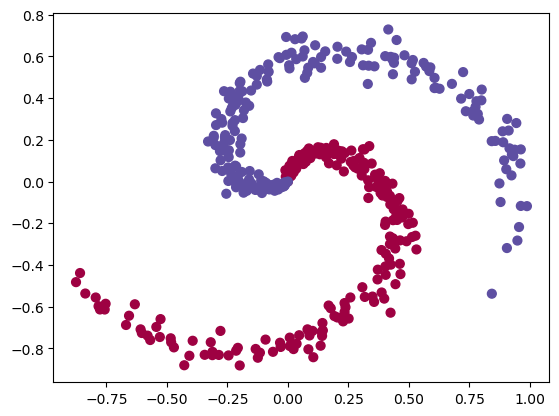

Accuracy: 0.9975


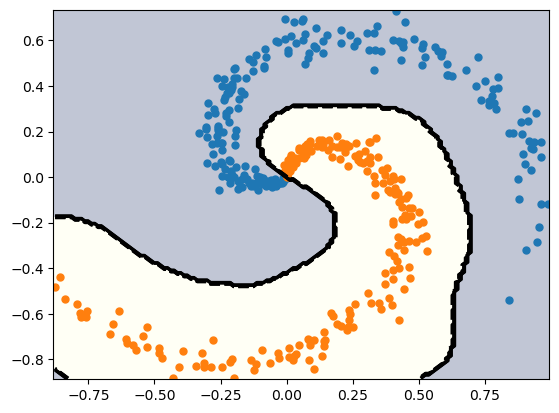

In [22]:
np.random.seed(1)
X1, y1 = create_dataset(N=200)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# C = 1
# y_train = y_train.reshape(-1,1) * 1.
# alphas = Soft_Margin(X_train,y_train,C)
# w = ((y_train * alphas).T @ X_train).reshape(-1,1)
# S = ((alphas > 1e-4 )&(alphas <=C)).flatten()
# b = y_train[S] - np.dot(X_train[S], w)
# b = b[0]
# #Display results
# print('Alphas = ',alphas[S])
# print('w = ', w.flatten())
# print('b = ', b[0])
# y_predict =  predict(X_test,w,b)
# print('Accuracy = ',calculate_accuracy(y_predict,y_test))

svm = Non_linear(kernel=rbf)
svm.fit(X1, y1)
y_pred = svm.predict(X1)
visualizeBoundary(X1,y1,svm)
print(f"Accuracy: {sum(y1==y_pred)/y1.shape[0]}")

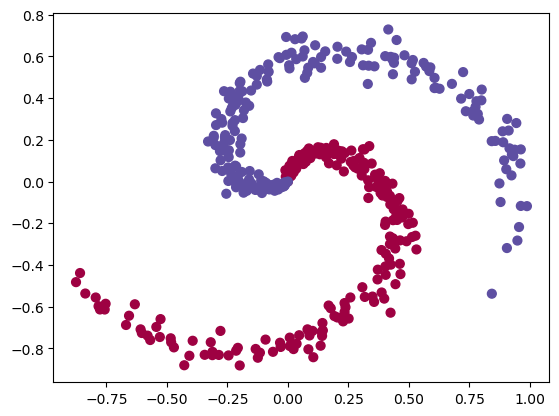

error =  0.012500000000000011


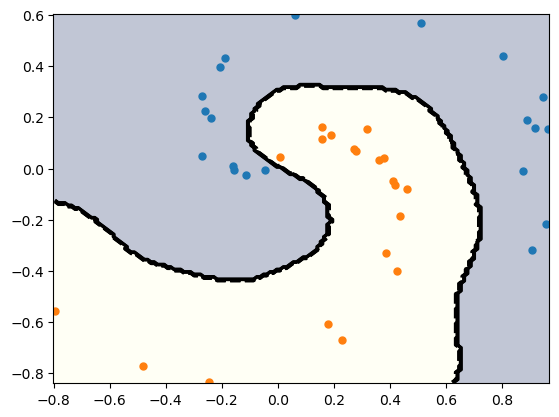

In [23]:
np.random.seed(1)
X1, y1 = create_dataset(N=200)
# X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X1,y1, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42)
# C = 1
# y_train = y_train.reshape(-1,1) * 1.
# alphas = Soft_Margin(X_train,y_train,C)
# w = ((y_train * alphas).T @ X_train).reshape(-1,1)
# S = ((alphas > 1e-4 )&(alphas <=C)).flatten()
# b = y_train[S] - np.dot(X_train[S], w)
# b = b[0]
# #Display results
# print('Alphas = ',alphas[S])
# print('w = ', w.flatten())
# print('b = ', b[0])
# y_predict =  predict(X_test,w,b)
# print('Accuracy = ',calculate_accuracy(y_predict,y_test))

svm = Non_linear(kernel=rbf)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_pred2 = svm.predict(X_valid)
acc1 = calculate_accuracy(y_pred,y_test)
acc2 = calculate_accuracy(y_pred2,y_valid)
print('error = ',calculate_error(acc1,acc2))
visualizeBoundary(X_test,y_test,svm)